<a href="https://www.kaggle.com/code/kuhelisen/mnist-cnn?scriptVersionId=108869056" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Load all libraries
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load all sklearn libraries
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

#import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import tensorflow.compat.v2 as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter
#Enable eager execution
#tf.enable_v2_behavior()

In [2]:
# Import the libraries:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Fix the seeds to reproduce the results:
SEED = 101
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# import training dataset:
train = pd.read_csv("../input/digit-recognizer/train.csv")
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# separate the label and features:
X =  train.drop(['label'], 1).values
y = train['label'].values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [5]:
# normalize the training set:
X = X/ 255.0


In [6]:
# print the shape of features:
print(X.shape)


(42000, 784)


In [7]:
# load dataset as train and test:
#(train_X, y_train), (test_X, y_test) = mnist.load_data()
# reshape dataset to have a single channel
X = X.reshape(-1, 28, 28, 1)


In [8]:
from sklearn.model_selection import train_test_split
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
# print the shape of the train feature(image) and train label(digits)
print(f'train_images.shape = {X_train.shape}; train_labels.shape = {y_train.shape}')

train_images.shape = (33600, 28, 28, 1); train_labels.shape = (33600,)


In [10]:
# print the shape of the test feature(image) and test label(digits)
print(f'test_images.shape = {X_test.shape}')

test_images.shape = (8400, 28, 28, 1)


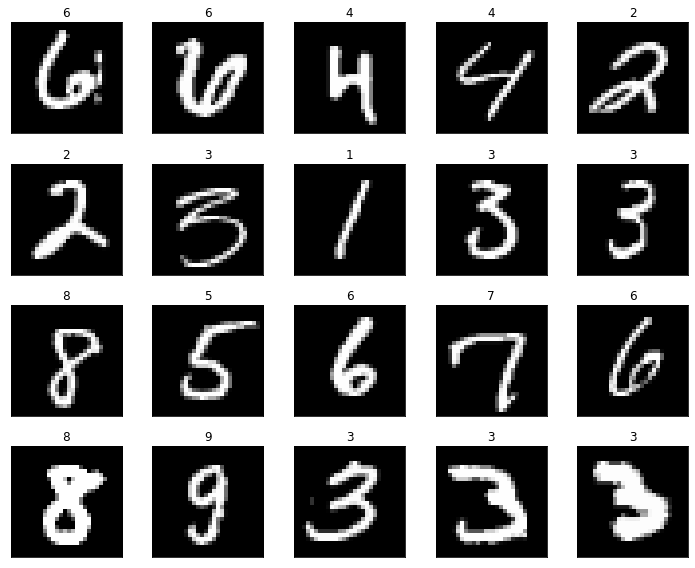

In [11]:
# Display the first 20 images
fig, ax = plt.subplots(4, 5, figsize = (10, 8))   # Create a 5x4 plot
ax = ax.ravel()                                   # Flatten the array (helps with the for loop)

# Use a for loop to get the first 20, adding each as a plot
for idx in range(20) :
    ax[idx].imshow(X_train[idx,:,:], cmap=plt.get_cmap('gray'))   # The image
    ax[idx].set_title(y_train[idx])                                  # The value
    ax[idx].axes.xaxis.set_ticks([])                                 # Remove x axis
    ax[idx].axes.yaxis.set_ticks([])                                 # Remove y axis
    
plt.tight_layout()
plt.show()

**Building the Convolutional Neural Network (CNN) model using TensorFlow:**

In [12]:
model = models.Sequential()
# Get the image size using codes instead of using magic number (32,32,3)
#input_shape = tf.reshape(X_train, [-1, 28, 28, 3])
input_shape =X_train.shape
print(f'The input shape = {input_shape[1:]}')
# The first Convolution layer (input layer) has 32 filters, with the output has 32 channels. The size of the filter is 3*3
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= input_shape[1:]))
model.add(BatchNormalization())
# The first Convolution layer has 32 filters, with the output has 32 channels. The size of the filter is 3*3
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
# Followed by 2*2 pooling window 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
# The second Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 3*3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
# Followed by 2*2 pooling window 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Dropout(0.25))
# The second Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 3*3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
# The Third Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 2*2
model.add(layers.Conv2D(512, (2, 2), activation='relu'))
model.add(BatchNormalization()) 
model.add(layers.Dropout(0.5))

2022-10-23 03:10:29.783434: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


The input shape = (28, 28, 1)


**Summarizing the model structures as follows:**

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        1

The height and width of the image decrease from (26,26) to (13,13), ... (2,2).

But we increase the number of filters/channels in the Conv2d operation

The pooling method doesn't change the number of channels, and it only shrinks the image size.

**Since the input is a 4D matrix therefore we need to flattens the input from a 4D to a 2D matrix. There are ten unique cases in the label, so the last layer must use ten neurons.**

In [14]:
# Convert  feature matrix from 4D to 2D
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
# Add dropout layer
model.add(layers.Dropout(0.5))
# Last layer must have 10 neuron to match the label
model.add(layers.Dense(10))


**Summarizing the model architecture. The output shape must be converted from 4D to 2D.**

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        1

**Plotting both the input and output layer as follows:**

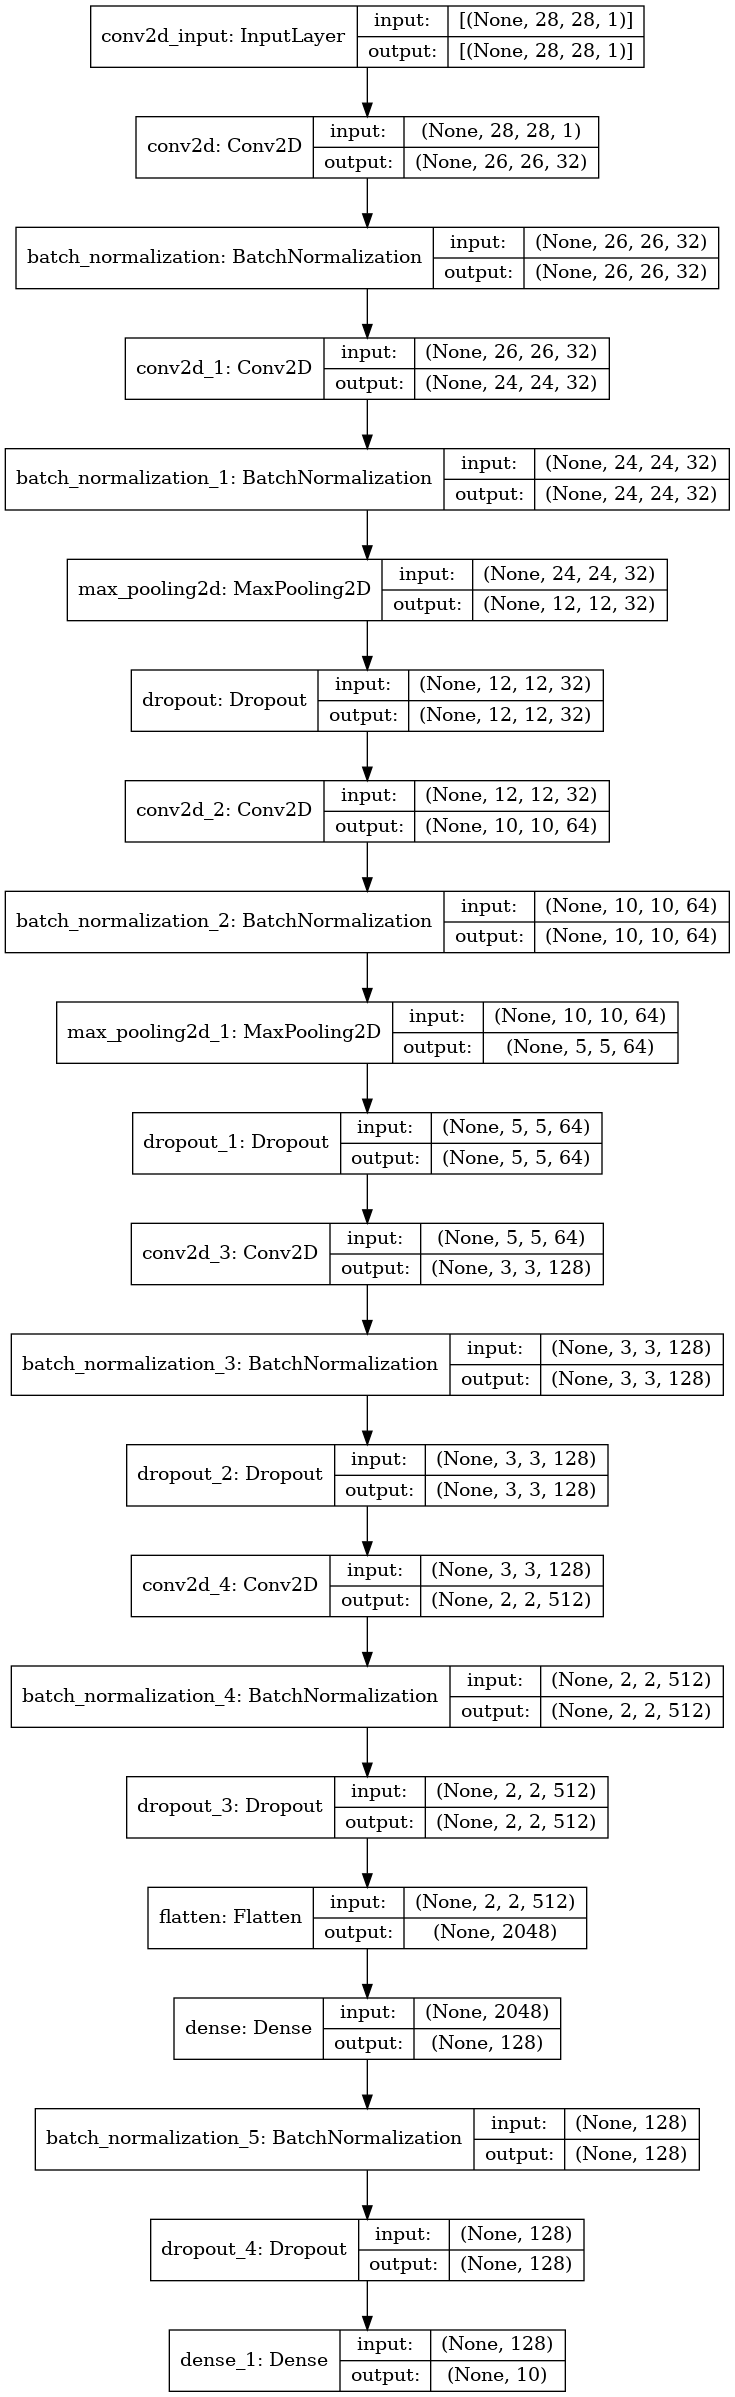

In [16]:
dot_img_file = 'CNNmodel.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

**Configure the Model:**

In [17]:
# It is a multiclass classification problem; the label is encoded as an integer.
# Therefore the loss function should be tf.keras.losses.SparseCategoricalCrossentropy:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Train the Model:**

In [18]:
# Train the model without early stopping (Stop training when a monitored metric has stopped improving):

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_test, y_test), verbose = 1)

2022-10-23 03:10:32.364519: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
1050/1050 [==============================] - 54s 50ms/step - loss: 0.3443 - accuracy: 0.8959 - val_loss: 0.0686 - val_accuracy: 0.9777
Epoch 2/20
1050/1050 [==============================] - 51s 49ms/step - loss: 0.1229 - accuracy: 0.9634 - val_loss: 0.0447 - val_accuracy: 0.9862
Epoch 3/20
1050/1050 [==============================] - 51s 48ms/step - loss: 0.0950 - accuracy: 0.9721 - val_loss: 0.0487 - val_accuracy: 0.9840
Epoch 4/20
1050/1050 [==============================] - 52s 49ms/step - loss: 0.0814 - accuracy: 0.9749 - val_loss: 0.0432 - val_accuracy: 0.9871
Epoch 5/20
1050/1050 [==============================] - 52s 49ms/step - loss: 0.0780 - accuracy: 0.9763 - val_loss: 0.0363 - val_accuracy: 0.9880
Epoch 6/20
1050/1050 [==============================] - 51s 49ms/step - loss: 0.0707 - accuracy: 0.9796 - val_loss: 0.0414 - val_accuracy: 0.9893
Epoch 7/20
1050/1050 [==============================] - 52s 50ms/step - loss: 0.0630 - accuracy: 0.9805 - val_loss: 0.0318 -

**Evaluate the model by checking the in-sample fit and out of sample fit:**

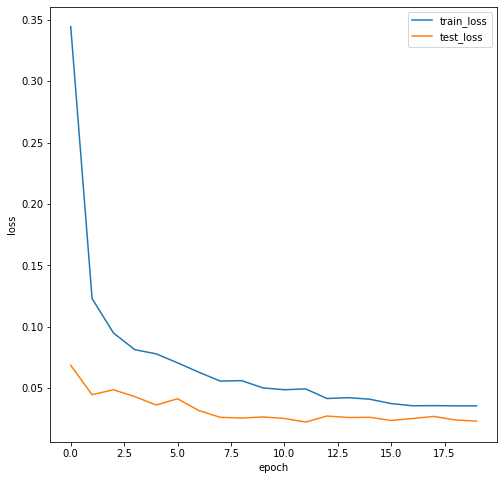

In [19]:
## Evaluate the Model
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'test_loss'])

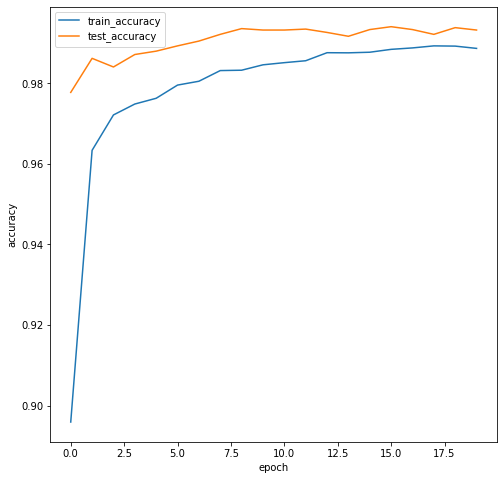

In [20]:
plt.figure(figsize=(8, 8))
# Plot training accuracy
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation accuracy
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'test_accuracy'])

The above output shows there is a rapid increase in train_accuracy from epoch 0 to 1 and then there is a steady increase in accuracy from epoch 1 to 17. Test_accuracy also increases steadily from epoch 1 to 17. There is still room for improvement in test accuracy.

#### Compute the loss and accuracy for the test dataset as follows:

In [21]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=0)
print(f' The test loss ={test_loss:.2f} and test accuracy = {test_acc:.2f}')

 The test loss =0.02 and test accuracy = 0.99


In [22]:
# Predict the test datadet:
y_pred = (model.predict(X_test))
Y_predict = np.argmax(y_pred, axis=1)


In [23]:
# Print the classification report
print(classification_report(y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       813
           1       1.00      0.99      1.00       961
           2       0.99      1.00      1.00       860
           3       1.00      1.00      1.00       863
           4       1.00      0.98      0.99       827
           5       1.00      0.99      1.00       756
           6       0.99      1.00      0.99       841
           7       0.99      0.99      0.99       899
           8       1.00      0.99      1.00       768
           9       0.98      0.99      0.99       812

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



In [24]:
# actual and predicted values:
Y_label = pd.DataFrame(y_test)
Y_Predict = pd.DataFrame(Y_predict)
predictions = pd.concat([Y_label, Y_Predict], axis = 1)
predictions.columns = ['Label', 'Prediction']
predictions

,Label,Prediction
0,3,3
1,6,6
2,9,9
3,5,5
4,6,6
...,...,...
8395,9,9
8396,2,2
8397,2,2
8398,7,7


In [25]:
# selected rows with correct predictions:
wrong_pred = predictions.loc[(predictions['Label'] != predictions['Prediction'],['Label', 'Prediction'])]
wrong_pred


,Label,Prediction
514,1,6
601,9,0
616,5,6
845,2,0
856,7,9
1051,7,9
1068,4,9
1146,4,9
1171,9,4
1367,4,9


Number of mismatches:  57


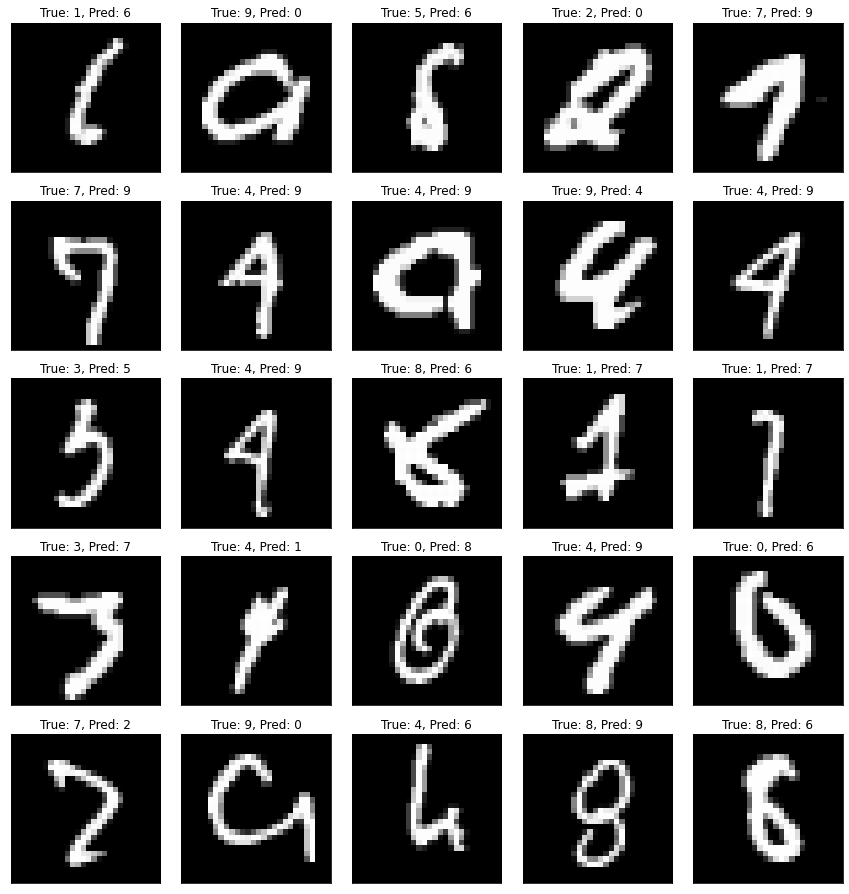

In [26]:
# Display mis-matched items, up to 40 of them
mismatch = np.where(y_test != Y_predict )
num_mismatch = len(mismatch[0])
print("Number of mismatches: ", num_mismatch)

# Set up the number of rows for output
rows = min(5, num_mismatch//5 + 1)


fig, ax = plt.subplots(rows, 5, figsize = (12, rows * 20/8))
ax = ax.ravel()

for i in range(min(len(mismatch[0]), 25)) :
    idx = mismatch[0][i]
    
    ax[i].imshow(np.reshape(X_test[idx], (28, 28)), cmap=plt.get_cmap('gray'))  # The image
    ax[i].set_title("True: {}, Pred: {}".format(y_test[idx], Y_predict [idx]))      # The value & prediction
    ax[i].axes.xaxis.set_ticks([])                                              # Remove x axis
    ax[i].axes.yaxis.set_ticks([])                                              # Remove y axis

if ((num_mismatch < 27) & (num_mismatch % 5 > 0)):
    for i2 in range(i, 5 * rows) :
        # Remove everything for the remaining plots
        ax[i2].axis('off')
        

plt.tight_layout()
plt.show()

In [27]:
# confusion matrix with actual values (index values) and column names as the predicted values:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_predict)

cm_df = pd.DataFrame(cm)
cm_df

,0,1,2,3,4,5,6,7,8,9
0,807,0,0,0,0,0,5,0,1,0
1,0,956,0,0,0,0,1,4,0,0
2,1,0,857,0,0,0,0,2,0,0
3,0,0,1,859,0,1,0,2,0,0
4,0,3,0,0,813,0,1,1,0,9
5,1,0,0,1,0,751,3,0,0,0
6,0,0,0,0,1,0,840,0,0,0
7,0,1,3,0,0,0,0,892,0,3
8,0,0,1,0,0,0,2,0,764,1
9,3,0,0,0,1,1,0,1,2,804


In [28]:
# read the test dataset as follows:
test = pd.read_csv("../input/digit-recognizer/test.csv")
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# change the test set into a list:
test_X =  test.values

In [30]:
# normalize the test set:
test_X = test_X/ 255.0

In [31]:
# shape of the test set:
test_X.shape

(28000, 784)

In [32]:
# flatten the array as follows:
test_X = test_X.reshape(-1, 28, 28, 1)

In [33]:
# now the shape of the test set:
test_X.shape

(28000, 28, 28, 1)

In [34]:
# Predict the test datadet:
pred = (model.predict(test_X))
predict = np.argmax(pred, axis=1)


In [35]:
Predict = pd.DataFrame(predict)


In [36]:
x= range(1,28001)
Predict['Imageid']=pd.DataFrame(x)
Predict.columns = ['Label', 'Imageid']
Predict

,Label,Imageid
0,2,1
1,0,2
2,9,3
3,9,4
4,3,5
...,...,...
27995,9,27996
27996,7,27997
27997,3,27998
27998,9,27999


In [37]:
Predict.to_csv('submission.csv', index=False)

The accuracy for the test set is 99.36%. 